#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18 Forecasting daily ticket sales for a swimming pool**

using using swim data

version 1.0 2021-05-05

In [1]:
# Import the pandas_market_calendars module
%pip install pandas_market_calendars
import pandas_market_calendars as mcal

import os
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
from mizani.formatters import date_format
from patsy import dmatrices
from plotnine import *
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

import seaborn as sns
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


### Read data

In [2]:
data = pd.read_csv("/workspaces/codespaces-jupyter/data/RC_F01_07_1992_T04_02_2025.csv", parse_dates=["date"])
data.columns = ["currency_rate", "date"]
data


,currency_rate,date
0,125.2600,1992-07-01
1,134.8000,1992-07-03
2,130.5000,1992-07-08
3,130.3000,1992-07-10
4,130.2000,1992-07-15
...,...,...
7514,97.9658,2025-01-29
7515,98.0126,2025-01-30
7516,98.0062,2025-01-31
7517,97.8107,2025-02-01


In [3]:
data_25 = pd.read_csv("/workspaces/codespaces-jupyter/data/Rtsudcur.csv")
data_25

,#Date;Value 18:50 MSK
0,2025-08-22;80.7498
1,2025-08-21;80.2548
2,2025-08-20;80.1045
3,2025-08-19;80.3466
4,2025-08-18;80.4256
...,...
160,2025-01-10;101.9146
161,2025-01-09;102.2911
162,2025-01-08;101.6797
163,2025-01-06;101.6797


In [4]:
# Split the column into two separate columns
data_25[["date_25", "currency_rate_25"]] = data_25["#Date;Value 18:50 MSK"].str.split(";", expand=True)

# Convert the new columns to appropriate data types
data_25["date_25"] = pd.to_datetime(data_25["date_25"])
data_25["currency_rate_25"] = pd.to_numeric(data_25["currency_rate_25"])

# Drop the original column as it is no longer needed
data_25 = data_25.drop(columns=["#Date;Value 18:50 MSK"])

data_25

,date_25,currency_rate_25
0,2025-08-22,80.7498
1,2025-08-21,80.2548
2,2025-08-20,80.1045
3,2025-08-19,80.3466
4,2025-08-18,80.4256
...,...,...
160,2025-01-10,101.9146
161,2025-01-09,102.2911
162,2025-01-08,101.6797
163,2025-01-06,101.6797


In [5]:
merged_data = pd.merge(data, data_25, left_on="date", right_on="date_25", how="outer")
merged_data

,currency_rate,date,date_25,currency_rate_25
0,125.26,1992-07-01,NaT,NaN
1,134.80,1992-07-03,NaT,NaN
2,130.50,1992-07-08,NaT,NaN
3,130.30,1992-07-10,NaT,NaN
4,130.20,1992-07-15,NaT,NaN
...,...,...,...,...
7665,NaN,NaT,2025-08-18,80.4256
7666,NaN,NaT,2025-08-19,80.3466
7667,NaN,NaT,2025-08-20,80.1045
7668,NaN,NaT,2025-08-21,80.2548


In [6]:
merged_data["date"] = merged_data["date"].fillna(merged_data["date_25"])
merged_data["currency_rate"] = merged_data["currency_rate"].fillna(merged_data["currency_rate_25"])
merged_data = merged_data.drop(columns=["date_25", "currency_rate_25"])
data=merged_data
data

,currency_rate,date
0,125.2600,1992-07-01
1,134.8000,1992-07-03
2,130.5000,1992-07-08
3,130.3000,1992-07-10
4,130.2000,1992-07-15
...,...,...
7665,80.4256,2025-08-18
7666,80.3466,2025-08-19
7667,80.1045,2025-08-20
7668,80.2548,2025-08-21


In [7]:
data["year"] = data["date"].dt.year
data["quarter"] = data["date"].dt.quarter
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["dow"] = data["date"].dt.dayofweek + 1
data["weekend"] = data["dow"].isin([6, 7])

data

,currency_rate,date,year,quarter,month,day,dow,weekend
0,125.2600,1992-07-01,1992,3,7,1,3,False
1,134.8000,1992-07-03,1992,3,7,3,5,False
2,130.5000,1992-07-08,1992,3,7,8,3,False
3,130.3000,1992-07-10,1992,3,7,10,5,False
4,130.2000,1992-07-15,1992,3,7,15,3,False
...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False
7666,80.3466,2025-08-19,2025,3,8,19,2,False
7667,80.1045,2025-08-20,2025,3,8,20,3,False
7668,80.2548,2025-08-21,2025,3,8,21,4,False


In [8]:
data.tail()

,currency_rate,date,year,quarter,month,day,dow,weekend
7665,80.4256,2025-08-18,2025,3,8,18,1,False
7666,80.3466,2025-08-19,2025,3,8,19,2,False
7667,80.1045,2025-08-20,2025,3,8,20,3,False
7668,80.2548,2025-08-21,2025,3,8,21,4,False
7669,80.7498,2025-08-22,2025,3,8,22,5,False


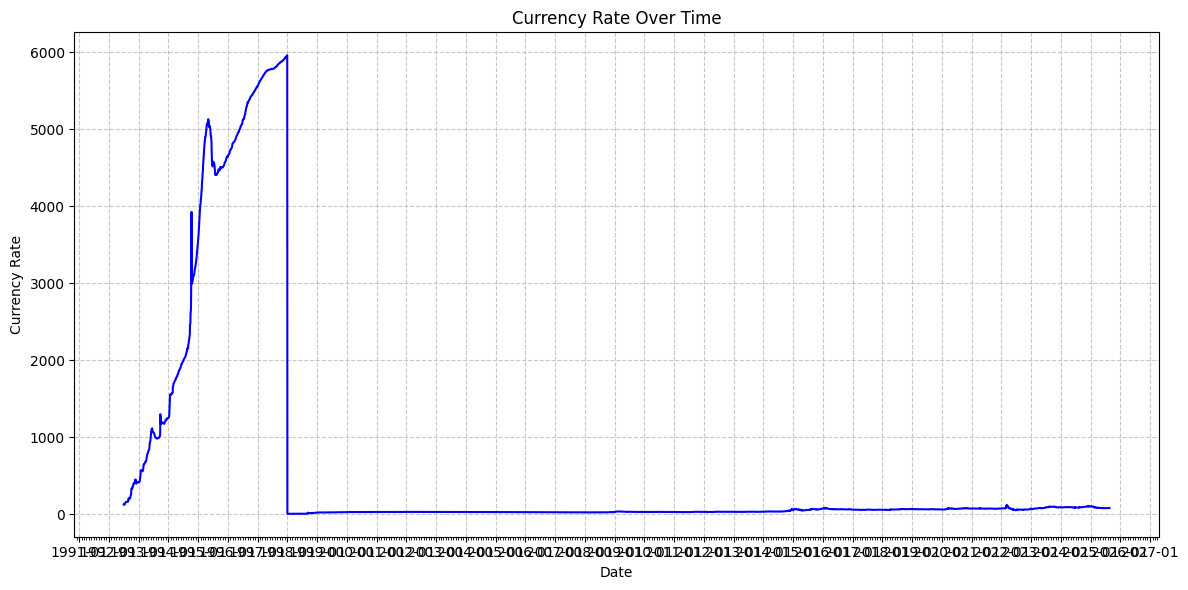

In [9]:
import matplotlib.dates as mdates  # Import mdates for date formatting

# Create a line plot with date on the x-axis and currency rate on the y-axis
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="date", y="currency_rate", color="blue")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Currency Rate")
plt.title("Currency Rate Over Time")

# Format the x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Calculate the daily percentage change in the currency rate
data['currency_rate_change'] = data['currency_rate'].pct_change() * 100

# Find the date with the largest absolute percentage change
significant_change = data.loc[data['currency_rate_change'].abs().idxmax()]
significant_change_date = significant_change['date']
significant_change_value = significant_change['currency_rate_change']

significant_change_date, significant_change_value

(Timestamp('1998-01-01 00:00:00'), -99.9)

In [11]:
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change
794,5955.000,1997-12-25,1997,4,12,25,4,False,0.084034
795,5955.000,1997-12-26,1997,4,12,26,5,False,0.000000
796,5958.000,1997-12-27,1997,4,12,27,6,True,0.050378
797,5960.000,1997-12-30,1997,4,12,30,2,False,0.033568
798,5.960,1998-01-01,1998,1,1,1,4,False,-99.900000
799,5.963,1998-01-06,1998,1,1,6,2,False,0.050336
800,5.969,1998-01-07,1998,1,1,7,3,False,0.100620


In [12]:
data["denomination"] = np.where(data["date"] <= "1997-12-30", "pre", "post")
data["RUB"] = np.where(data["denomination"] == "pre", data["currency_rate"]/1000, data["currency_rate"])
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020
...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.42560
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.34660
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.10450
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.25480


In [13]:
data_year = data.groupby("year").agg({"RUB": "mean"}).reset_index()
data_year

,year,RUB
0,1992,0.284345
1,1993,0.936061
2,1994,2.227129
3,1995,4.558707
4,1996,5.217653
5,1997,5.786362
6,1998,9.794531
7,1999,24.648920
8,2000,28.128725
9,2001,29.175301


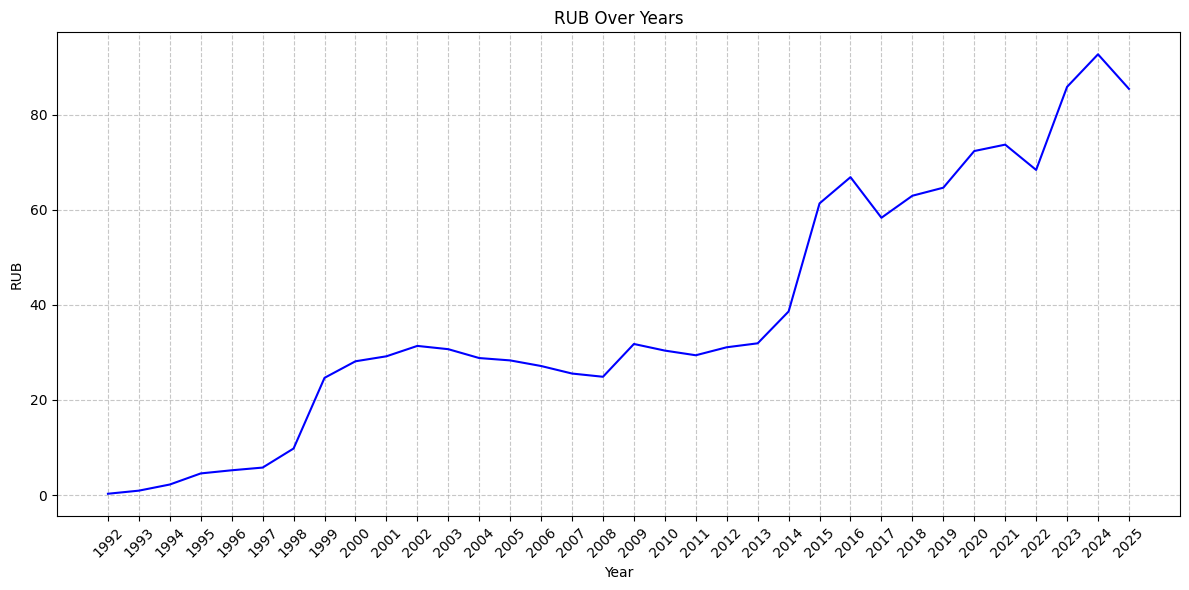

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_year, x="year", y="RUB", color="blue")

# Add labels and title
plt.xlabel("Year")
plt.ylabel("RUB")
plt.title("RUB Over Years")

# Set ticks explicitly to unique years
plt.xticks(ticks=data_year["year"], labels=data_year["year"], rotation=45)

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

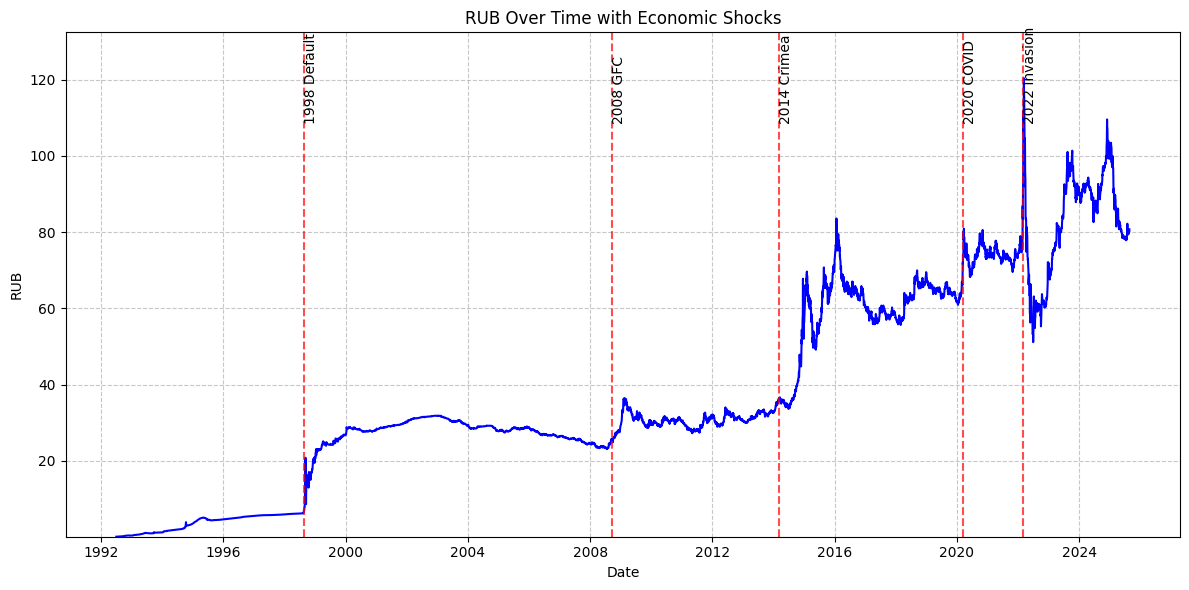

In [108]:
shocks = {
    "1998 Default": "1998-08-17",
    "2008 GFC": "2008-09-15",
    "2014 Crimea": "2014-03-01",
    "2020 COVID": "2020-03-11",
    "2022 Invasion": "2022-02-24"
}

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="date", y="RUB", color="blue")

# Add vertical lines and labels for shocks
for label, date in shocks.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), data['RUB'].max() * 0.9, label, rotation=90, verticalalignment='bottom')

# Adjust y-axis limits to remove the gap
plt.ylim(data['RUB'].min() * 0.9, data['RUB'].max() * 1.1)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("RUB Over Time with Economic Shocks")

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

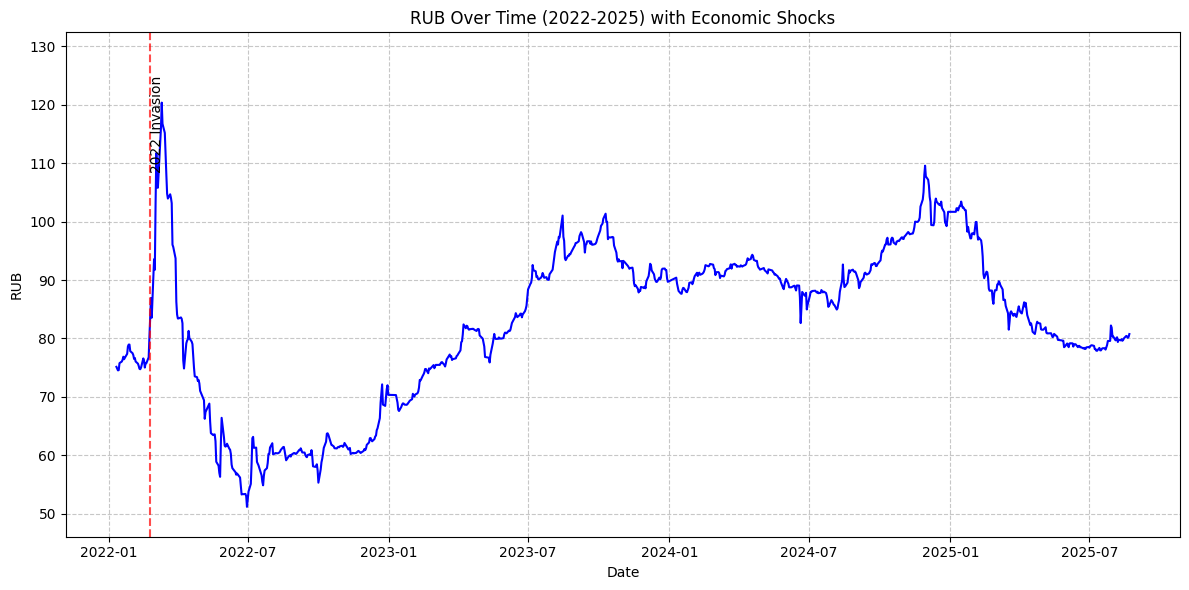

In [109]:
# Filter data for the years 2022 to 2025
filtered_data = data[(data["year"] >= 2022) & (data["year"] <= 2025)]

# Plot the filtered data
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="date", y="RUB", color="blue")

# Add vertical lines and labels for shocks within the filtered range
for label, date in shocks.items():
    shock_date = pd.to_datetime(date)
    if shock_date.year >= 2022 and shock_date.year <= 2025:
        plt.axvline(shock_date, color='red', linestyle='--', alpha=0.7)
        plt.text(shock_date, filtered_data['RUB'].max() * 0.9, label, rotation=90, verticalalignment='bottom')

# Adjust y-axis limits to remove the gap
plt.ylim(filtered_data['RUB'].min() * 0.9, filtered_data['RUB'].max() * 1.1)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("RUB Over Time (2022-2025) with Economic Shocks")

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [100]:
data[data["date"]=='2025-08-18']

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,0.4032


In [112]:
GDP_per_capita = pd.read_csv("/workspaces/codespaces-jupyter/data/GDP per capita (current US$).csv",skiprows=4)
GDP_deflator = pd.read_csv("/workspaces/codespaces-jupyter/data/GDP deflator (annual %).csv", skiprows=4)
FD_investment = pd.read_csv("/workspaces/codespaces-jupyter/data/Foreign direct investment.csv", skiprows=4)

In [113]:
GDP_per_capita_RUS = GDP_per_capita[GDP_per_capita["Country Code"] == "RUS"]

GDP_per_capita_RUS = GDP_per_capita_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_per_capita_RUS = GDP_per_capita_RUS.reset_index()
GDP_per_capita_RUS.columns = ["year", "GDP_per_capita"]
GDP_per_capita_RUS = GDP_per_capita_RUS[GDP_per_capita_RUS["year"].str.isdigit()]

GDP_per_capita_RUS

,year,GDP_per_capita
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,10108.327148
61,2021,12425.029297
62,2022,15619.614258
63,2023,14159.387695


In [114]:
GDP_deflator_RUS = GDP_deflator[GDP_deflator["Country Code"] == "RUS"]

GDP_deflator_RUS = GDP_deflator_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_deflator_RUS = GDP_deflator_RUS.reset_index()
GDP_deflator_RUS.columns = ["year", "GDP_deflator"]
GDP_deflator_RUS = GDP_deflator_RUS[GDP_deflator_RUS["year"].str.isdigit()]

GDP_deflator_RUS

,year,GDP_deflator
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,0.898246
61,2021,18.209101
62,2022,18.184689
63,2023,7.998571


In [115]:
FD_investment_RUS = FD_investment[FD_investment["Country Code"] == "RUS"]

FD_investment_RUS = FD_investment[FD_investment["Country Code"] == "RUS"]
FD_investment_RUS = FD_investment_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
FD_investment_RUS = FD_investment_RUS.reset_index()
FD_investment_RUS.columns = ["year", "FD_investment"]
FD_investment_RUS = FD_investment_RUS[FD_investment_RUS["year"].str.isdigit()]

FD_investment_RUS

,year,FD_investment
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,9.478810e+09
61,2021,4.045000e+10
62,2022,-3.980094e+10
63,2023,-1.004511e+10


### Checking stationarity

In [17]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the RUB column
result = adfuller(data["RUB"].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -1.293880499277948
p-value: 0.6319673214926411
Critical Values: {'1%': -3.431206441353405, '5%': -2.8619184832442954, '10%': -2.56697146213229}


In [18]:
data["RUB_diff"] = data["RUB"].diff().dropna()

result = adfuller(data["RUB_diff"].dropna())
print("ADF Statistic (1st diff):", result[0])
print("p-value:", result[1])

ADF Statistic (1st diff): -15.06612858554876
p-value: 8.86028697354434e-28


In [19]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526,NaN
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480,0.00954
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050,-0.00430
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030,-0.00020
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020,-0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.42560,0.40320
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.34660,-0.07900
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.10450,-0.24210
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.25480,0.15030


### ARIMA with 1, 1, 1 without train/test and CV - ARIMA Test

In [117]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526,NaN
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480,0.00954
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050,-0.00430
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030,-0.00020
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020,-0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.42560,0.40320
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.34660,-0.07900
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.10450,-0.24210
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.25480,0.15030


In [118]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA with (p=1, d=1, q=1) as a starting point
model = ARIMA(data["RUB"], order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                 7670
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6882.992
Date:                Mon, 25 Aug 2025   AIC                          13771.985
Time:                        02:58:23   BIC                          13792.820
Sample:                             0   HQIC                         13779.131
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6590      0.015     42.836      0.000       0.629       0.689
ma.L1         -0.5769      0.017    -33.699      0.000      -0.610      -0.543
sigma2         0.3524      0.001    318.998      0.0

In [ ]:
from pmdarima import auto_arima

# Run auto_arima
model = auto_arima(data["RUB"], 
                   start_p=0, max_p=5,
                   start_q=0, max_q=5,
                   d=None,              # Let auto_arima determine d
                   seasonal=False,      # Currency is usually non-seasonal
                   stepwise=True,       # Faster search
                   trace=True)          # Show search process

# Summary of best model
print(model.summary())

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-package

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13858.385, Time=0.61 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13780.379, Time=0.35 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13781.715, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13858.762, Time=0.10 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13781.784, Time=0.35 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13772.414, Time=1.66 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13767.177, Time=3.66 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13755.703, Time=3.40 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13760.042, Time=0.60 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13757.556, Time=6.45 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


### Splitting Data fro Prediction

In [ ]:
data_post_default = data[data["year"] >= 1998]
data_post_default

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff
798,5.9600,1998-01-01,1998,1,1,1,4,False,-99.900000,post,5.9600,0.0000
799,5.9630,1998-01-06,1998,1,1,6,2,False,0.050336,post,5.9630,0.0030
800,5.9690,1998-01-07,1998,1,1,7,3,False,0.100620,post,5.9690,0.0060
801,5.9720,1998-01-09,1998,1,1,9,5,False,0.050260,post,5.9720,0.0030
802,5.9740,1998-01-10,1998,1,1,10,6,True,0.033490,post,5.9740,0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,0.4032
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,-0.0790
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,-0.2421
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,0.1503


In [33]:
data["year"].value_counts().sort_index()

year
1992     53
1993     99
1994    101
1995     99
1996    196
1997    250
1998    251
1999    250
2000    251
2001    249
2002    250
2003    250
2004    251
2005    248
2006    248
2007    249
2008    249
2009    249
2010    249
2011    249
2012    249
2013    246
2014    247
2015    247
2016    248
2017    247
2018    247
2019    246
2020    243
2021    248
2022    247
2023    247
2024    248
2025    169
Name: count, dtype: int64

In [34]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2025, :]
data_work = data.loc[lambda x: x["year"] < 2025, :]

### Balanced CV with 13 recent years

In [37]:
# Start from 2005 + 13 = 2018 (to ensure 13 full years of training)
for year in range(2018, 2025):  # 2025 reserved for holdout
    fold = year - 2018  # fold0 corresponds to year=2018
    data_work[f"train{fold}"] = (data_work["year"] >= year - 13) & (data_work["year"] <= year - 1)
    data_work[f"test{fold}"] = data_work["year"] == year

# Define holdout (2025)
data_work["holdout"] = data_work["year"] == 2025

/tmp/ipykernel_2237/3847985813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2237/3847985813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2237/3847985813.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
data_work

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,...,train8,test9,train9,test10,train10,test11,train11,test12,train12,holdout
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,...,False,False,False,False,False,False,False,False,False,False
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,...,False,False,False,False,False,False,False,False,False,False
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,...,False,False,False,False,False,False,False,False,False,False
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,...,False,False,False,False,False,False,False,False,False,False
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,99.8729,2024-12-25,2024,4,12,25,3,False,-1.713735,post,...,False,False,False,False,False,False,False,True,False,False
7497,99.6125,2024-12-26,2024,4,12,26,4,False,-0.260731,post,...,False,False,False,False,False,False,False,True,False,False
7498,99.2295,2024-12-27,2024,4,12,27,5,False,-0.384490,post,...,False,False,False,False,False,False,False,True,False,False
7499,100.5281,2024-12-28,2024,4,12,28,6,True,1.308683,post,...,False,False,False,False,False,False,False,True,False,False


In [41]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

In [45]:
# 1. Run auto_arima to determine best ARIMA(p,d,q)
auto_model = auto_arima(
    data_work.currency_rate,
    start_p=0,
    max_p=1,  # AR = 1; Without this constrain, python returns other ARIMA order
    max_order=0, # p + q + P + Q <= 0
    seasonal=False,
)

# 2. Extract best order (p, d, q)
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation with 4 folds
mse_2 = []

for i in range(1, 5):
    # Create masks
    train_mask = data_work["train" + str(i)] == True
    test_mask  = data_work["test"  + str(i)] == True

    # Get y_train and y_test
    y_train = data_work.loc[train_mask, "currency_rate"].sort_index()
    y_test  = data_work.loc[test_mask,  "currency_rate"].sort_index()

    # Fit model on training data
    model = ARIMA(endog=y_train, order=best_order).fit()

    # Forecast exactly len(test) steps
    n_steps = len(y_test)
    phat = model.forecast(steps=n_steps)

    # Compute squared error
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/codespace/.local/lib/python3.12/site-package

Best ARIMA order: (0, 1, 0)


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `st

CV RMSE (Auto ARIMA): 9.760735073583787


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


In [46]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:          currency_rate   No. Observations:                 3215
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2873.093
Date:                Mon, 25 Aug 2025   AIC                           5748.185
Time:                        02:02:45   BIC                           5754.261
Sample:                             0   HQIC                          5750.363
                               - 3215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3499      0.002    158.659      0.000       0.346       0.354
Ljung-Box (L1) (Q):                   5.69   Jarque-Bera (JB):            115194.21
Prob(Q):                              0.02   Pr

In [79]:
# 1. Fit final model on full data
model_final = ARIMA(data_work.currency_rate, order=(0, 1, 0)).fit()

# 2. Forecast for 2025
n_steps = data_holdout.shape[0]  # Get number of periods in 2025
pred_final = model_final.get_forecast(steps=n_steps)

# 3. Extract forecast results and fix index to match data_holdout
pred_mean = pred_final.predicted_mean
conf_int = pred_final.conf_int(alpha=0.2)
conf_int.index = data_holdout.index  # 👈 This line ensures indexes align

# 4. Combine everything into one DataFrame
forecast_holdout_best = pd.concat([
    data_holdout.reset_index(drop=True),
    pred_mean.rename("currency_rate_pred").reset_index(drop=True),
    conf_int.reset_index(drop=True).rename(columns={
        conf_int.columns[0]: "lower currency_rate",
        conf_int.columns[1]: "upper currency_rate"
    }),
], axis=1)

# 5. Final plot-ready data
#data_plot = forecast_holdout_best[[
#     "date", "currency_rate", "currency_rate_pred", "lower currency_rate", "upper currency_rate"
#]]

In [80]:
forecast_holdout_best

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff,currency_rate_pred,lower currency_rate,upper currency_rate
0,101.6797,2025-01-03,2025,1,1,3,5,False,0.000000,post,101.6797,0.0000,101.6797,10.513707,192.845693
1,101.6797,2025-01-06,2025,1,1,6,1,False,0.000000,post,101.6797,0.0000,101.6797,-27.248484,230.607884
2,101.6797,2025-01-08,2025,1,1,8,3,False,0.000000,post,101.6797,0.0000,101.6797,-56.224432,259.583832
3,102.2911,2025-01-09,2025,1,1,9,4,False,0.601300,post,102.2911,0.6114,101.6797,-80.652286,284.011686
4,102.2911,2025-01-10,2025,1,1,10,5,False,0.000000,post,102.2911,0.0000,101.6797,-102.173658,305.533058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,0.4032,101.6797,-1069.368685,1272.728085
165,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,-0.0790,101.6797,-1072.911956,1276.271356
166,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,-0.2421,101.6797,-1076.444571,1279.803971
167,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,0.1503,101.6797,-1079.966624,1283.326024


In [81]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,RUB_diff
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526,NaN
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480,0.00954
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050,-0.00430
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030,-0.00020
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020,-0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.42560,0.40320
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.34660,-0.07900
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.10450,-0.24210
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.25480,0.15030


In [82]:
# Ensure date column exists and is aligned in both
forecast_holdout_best = forecast_holdout_best.reset_index()  # if date is in index
data_reset = data.reset_index()  # same here

# Merge by date column (you can use 'year' or 'date' depending on what you have)
data_plot = (
    data_reset
    .merge(forecast_holdout_best, on="date", how="left")
    .loc[lambda x: x.date.dt.year >= 2015]
    .reset_index(drop=True)
)

data_plot

,index_x,currency_rate_x,date,year_x,quarter_x,month_x,day_x,dow_x,weekend_x,currency_rate_change_x,...,day_y,dow_y,weekend_y,currency_rate_change_y,denomination_y,RUB_y,RUB_diff_y,currency_rate_pred,lower currency_rate,upper currency_rate
0,5033,56.2376,2015-01-01,2015,1,1,1,4,False,-0.036972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5034,62.7363,2015-01-13,2015,1,1,13,2,False,11.555792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5035,64.8425,2015-01-14,2015,1,1,14,3,False,3.357227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5036,66.0983,2015-01-15,2015,1,1,15,4,False,1.936693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5037,64.8337,2015-01-16,2015,1,1,16,5,False,-1.913211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,...,18.0,1.0,False,0.503859,post,80.4256,0.4032,101.6797,-1069.368685,1272.728085
2633,7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,...,19.0,2.0,False,-0.098227,post,80.3466,-0.0790,101.6797,-1072.911956,1276.271356
2634,7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,...,20.0,3.0,False,-0.301320,post,80.1045,-0.2421,101.6797,-1076.444571,1279.803971
2635,7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,...,21.0,4.0,False,0.187630,post,80.2548,0.1503,101.6797,-1079.966624,1283.326024


In [106]:
data_plot[data_plot["currency_rate_pred"].notnull()][["date", "currency_rate_x", "currency_rate_pred"]]

,date,currency_rate_x,currency_rate_pred
2468,2025-01-03,101.6797,101.6797
2469,2025-01-06,101.6797,101.6797
2470,2025-01-08,101.6797,101.6797
2471,2025-01-09,102.2911,101.6797
2472,2025-01-10,102.2911,101.6797
...,...,...,...
2632,2025-08-18,80.4256,101.6797
2633,2025-08-19,80.3466,101.6797
2634,2025-08-20,80.1045,101.6797
2635,2025-08-21,80.2548,101.6797


In [ ]:
# Filter the data for rows where predictions are not null
filtered_data = data_plot[data_plot["currency_rate_pred"].notnull()][["date", "currency_rate_x", "currency_rate_pred"]]

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="date", y="currency_rate_x", label="Actual", color="blue")
sns.lineplot(data=filtered_data, x="date", y="currency_rate_pred", label="Prediction", color="green")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Currency Rate")
plt.title("Actual vs Predicted Currency Rate")

# Format the x-axis for better readability
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

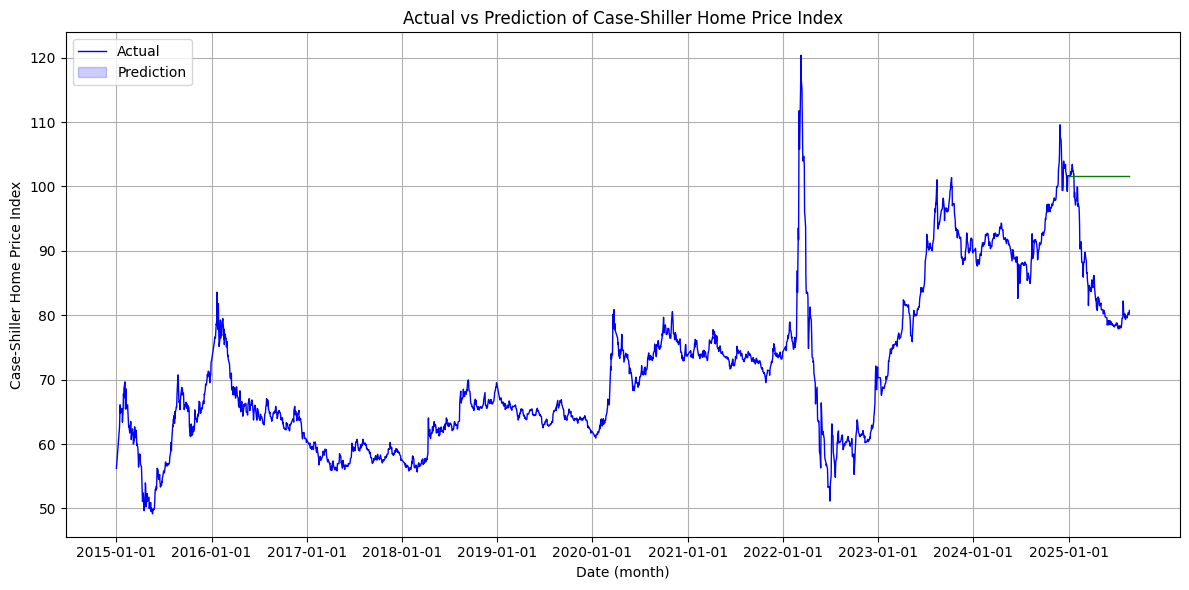

In [102]:
# Melt the data for plotting
data_plot_1 = pd.melt(data_plot.filter(["date", "currency_rate_x", "currency_rate_pred"]), ["date"])

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_plot_1, x="date", y="value", hue="variable", linewidth=1, palette={"currency_rate_x": "blue", "currency_rate_pred": "green"})

# Add labels and title
plt.ylabel("Case-Shiller Home Price Index")
plt.xlabel("Date (month)")
plt.title("Actual vs Prediction of Case-Shiller Home Price Index")

# Customize legend
plt.legend(title="", labels=["Actual", "Prediction"], loc="upper left")

# Format x-axis for better readability
plt.xticks(pd.date_range(start=data_plot_1["date"].min(), end=data_plot_1["date"].max(), freq="1YS"))

# Add grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [99]:
data_plot_1[data_plot_1["date"]=='2025-08-18']

,date,variable,value
2632,2025-08-18,currency_rate_change_x,0.503859
5269,2025-08-18,currency_rate_pred,101.679700


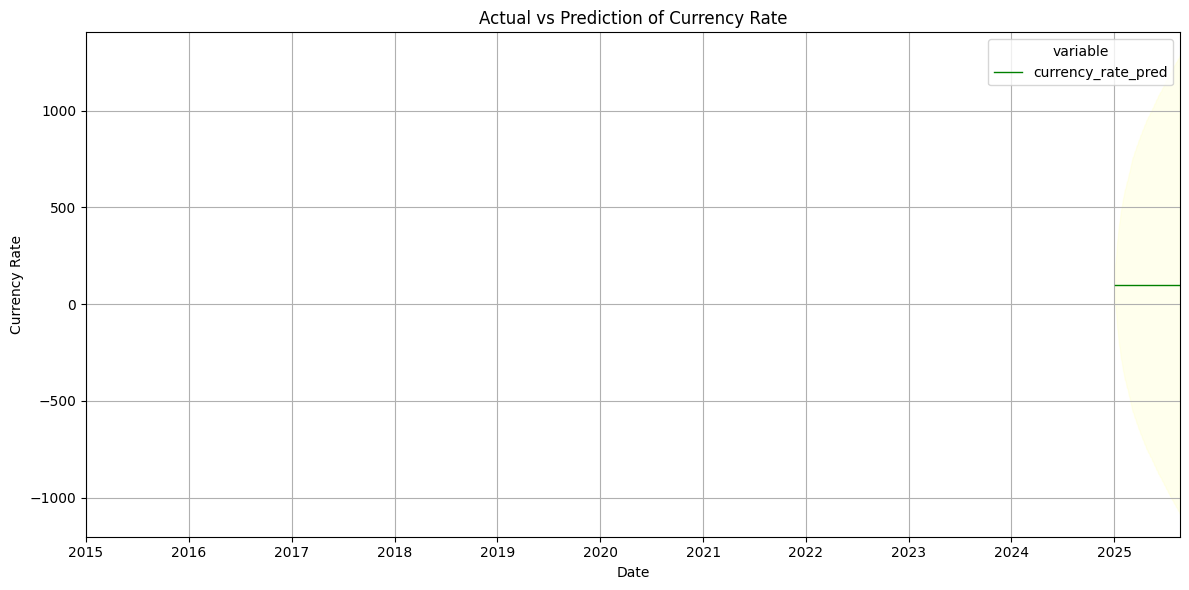

In [ ]:
# Reshape the data for plotting
data_plot_melted = pd.melt(
    data_plot.filter(["date", "Actual", "Prediction"]),
    id_vars=["date"],
    var_name="variable",
    value_name="value"
)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual and predicted values
sns.lineplot(data=data_plot_melted, x="date", y="value", hue="variable", linewidth=1, 
             palette={"currency_rate": "blue", "currency_rate_pred": "green"})

# Add confidence interval as a shaded area using the original data_plot DataFrame
plt.fill_between(
    data_plot["date"],
    data_plot["lower currency_rate"],
    data_plot["upper currency_rate"],
    color="#FFFFC5",
    alpha=0.3,
    label="Confidence Interval"
)

# Add labels and title
plt.ylabel("Currency Rate")
plt.xlabel("Date")
plt.title("Actual vs Prediction of Currency Rate")

# Set x-axis limits to show all dates
plt.xlim(data_plot["date"].min(), data_plot["date"].max())

# Add grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


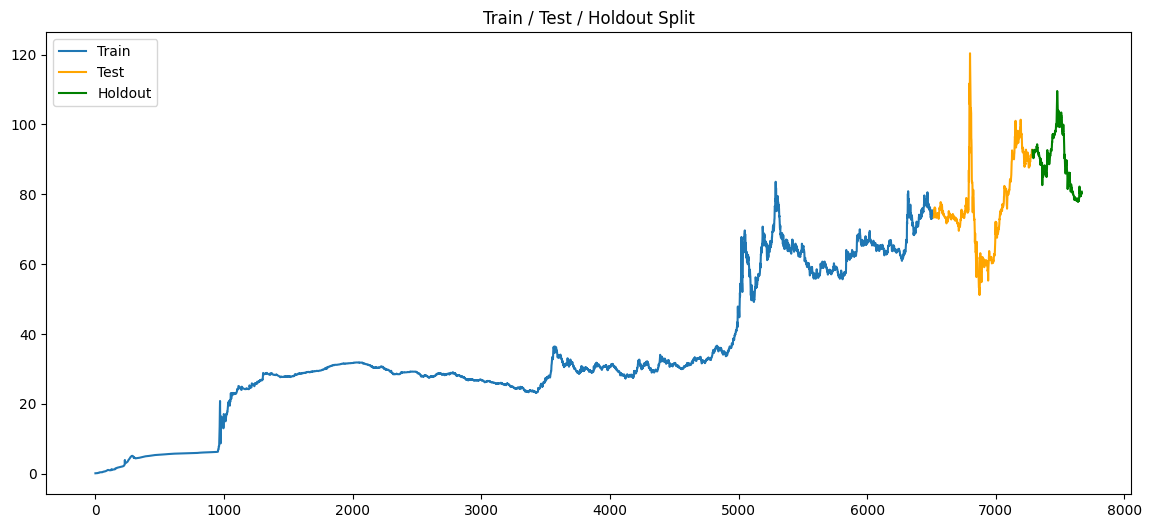

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train.index, train["RUB"], label="Train")
plt.plot(test.index, test["RUB"], label="Test", color="orange")
plt.plot(holdout.index, holdout["RUB"], label="Holdout", color="green")
plt.title("Train / Test / Holdout Split")
plt.legend()
plt.show()

In [ ]:
# 1. Run auto_arima to determine best ARIMA(p,d,q)
auto_model = auto_arima(
    train.p,
    start_p=0,
    max_p=1,  # AR = 1; Without this constrain, python returns other ARIMA order
    max_order=0, # p + q + P + Q <= 0
    seasonal=False,
)

# 2. Extract best order (p, d, q)
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation with 4 folds
mse_0 = []

for i in range(1, 5):
    # Create masks
    train_mask = data_work["train" + str(i)] == True
    test_mask  = data_work["test"  + str(i)] == True

    # Get y_train and y_test
    y_train = data_work.loc[train_mask, "p"].sort_index()
    y_test  = data_work.loc[test_mask,  "p"].sort_index()

    # Fit model on training data
    model = ARIMA(endog=y_train, order=best_order).fit()

    # Forecast exactly len(test) steps
    phat = model.forecast(steps=12)

    # Compute squared error
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)

In [17]:
!pip install wbdata

In [18]:
!pip install datetime

In [19]:
import wbdata
import pandas as pd
import datetime

In [20]:
country = "RUS"
indicators = {
    'NY.GDP.MKTP.CD': 'GDP (current US$)',
    'FP.CPI.TOTL.ZG': 'Inflation (CPI %)',
    'BX.KLT.DINV.CD.WD': 'FDI (net inflows)'
}

start_date = datetime.datetime(1992, 7, 1)
end_date = datetime.datetime(2025, 8, 22)


In [110]:
GDP_per_capita = pd.read_csv("/workspaces/codespaces-jupyter/data/GDP per capita (current US$).csv",skiprows=4)
GDP_deflator = pd.read_csv("/workspaces/codespaces-jupyter/data/GDP deflator (annual %).csv", skiprows=4)
FD_investment = pd.read_csv("/workspaces/codespaces-jupyter/data/Foreign direct investment.csv", skiprows=4)

In [22]:
GDP_per_capita_RUS = GDP_per_capita[GDP_per_capita["Country Code"] == "RUS"]

GDP_per_capita_RUS = GDP_per_capita_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_per_capita_RUS = GDP_per_capita_RUS.reset_index()
GDP_per_capita_RUS.columns = ["year", "GDP_per_capita"]
GDP_per_capita_RUS = GDP_per_capita_RUS[GDP_per_capita_RUS["year"].str.isdigit()]

GDP_per_capita_RUS

,year,GDP_per_capita
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,10108.327148
61,2021,12425.029297
62,2022,15619.614258
63,2023,14159.387695


In [31]:
GDP_deflator_RUS = GDP_deflator[GDP_deflator["Country Code"] == "RUS"]

GDP_deflator_RUS = GDP_deflator_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_deflator_RUS = GDP_deflator_RUS.reset_index()
GDP_deflator_RUS.columns = ["year", "GDP_deflator"]
GDP_deflator_RUS = GDP_deflator_RUS[GDP_deflator_RUS["year"].str.isdigit()]

GDP_deflator_RUS

,year,GDP_deflator
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,0.898246
61,2021,18.209101
62,2022,18.184689
63,2023,7.998571


In [32]:
FD_investment_RUS = FD_investment[FD_investment["Country Code"] == "RUS"]

FD_investment_RUS = FD_investment[FD_investment["Country Code"] == "RUS"]
FD_investment_RUS = FD_investment_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
FD_investment_RUS = FD_investment_RUS.reset_index()
FD_investment_RUS.columns = ["year", "FD_investment"]
FD_investment_RUS = FD_investment_RUS[FD_investment_RUS["year"].str.isdigit()]

FD_investment_RUS

,year,FD_investment
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,9.478810e+09
61,2021,4.045000e+10
62,2022,-3.980094e+10
63,2023,-1.004511e+10


/tmp/ipykernel_39130/30258625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


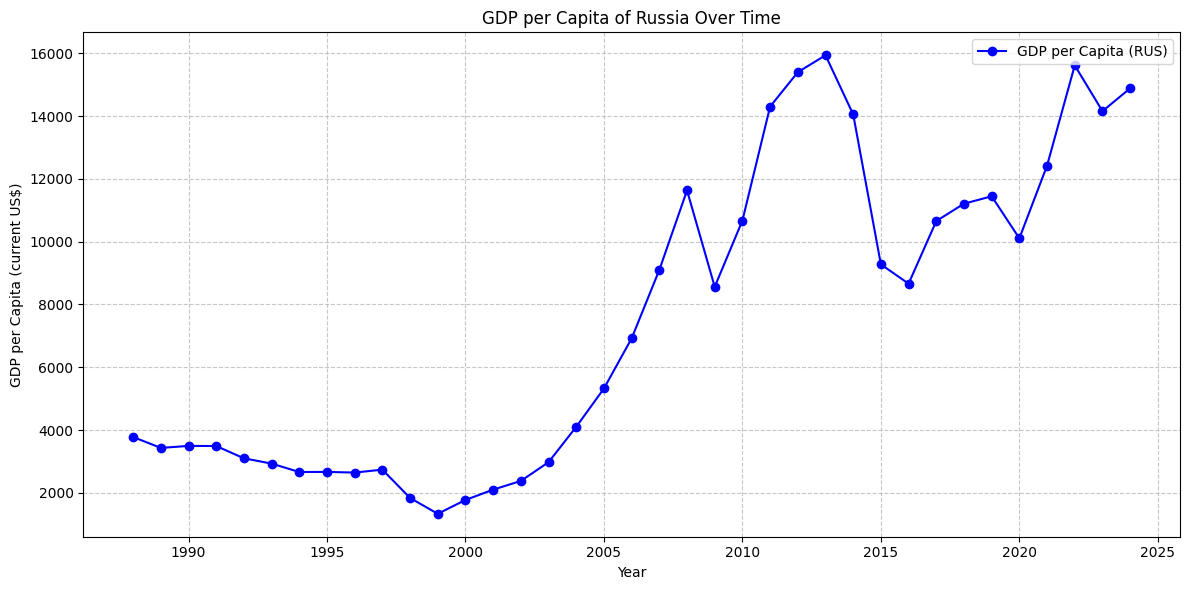

In [ ]:
GDP_per_capita_RUS_cleaned = GDP_per_capita_RUS.dropna(subset=["GDP_per_capita"])

# Convert the 'year' column to integer for plotting
GDP_per_capita_RUS_cleaned["year"] = GDP_per_capita_RUS_cleaned["year"].astype(int)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    GDP_per_capita_RUS_cleaned["year"],
    GDP_per_capita_RUS_cleaned["GDP_per_capita"],
    marker="o",
    linestyle="-",
    color="blue",
    label="GDP per Capita (RUS)"
)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("GDP per Capita (current US$)")
plt.title("GDP per Capita of Russia Over Time")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_39130/1164168808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


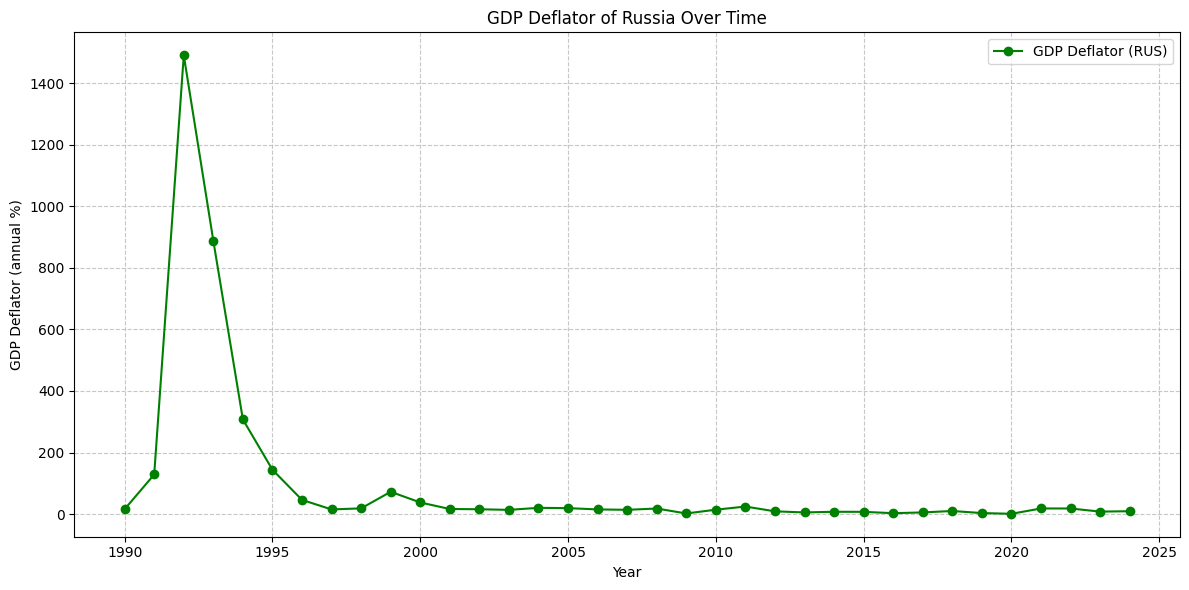

In [35]:
GDP_deflator_RUS_cleaned = GDP_deflator_RUS.dropna(subset=["GDP_deflator"])

# Convert the 'year' column to integer for plotting
GDP_deflator_RUS_cleaned["year"] = GDP_deflator_RUS_cleaned["year"].astype(int)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    GDP_deflator_RUS_cleaned["year"],
    GDP_deflator_RUS_cleaned["GDP_deflator"],
    marker="o",
    linestyle="-",
    color="green",
    label="GDP Deflator (RUS)"
)


# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("GDP Deflator (annual %)")
plt.title("GDP Deflator of Russia Over Time")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_39130/2549817777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


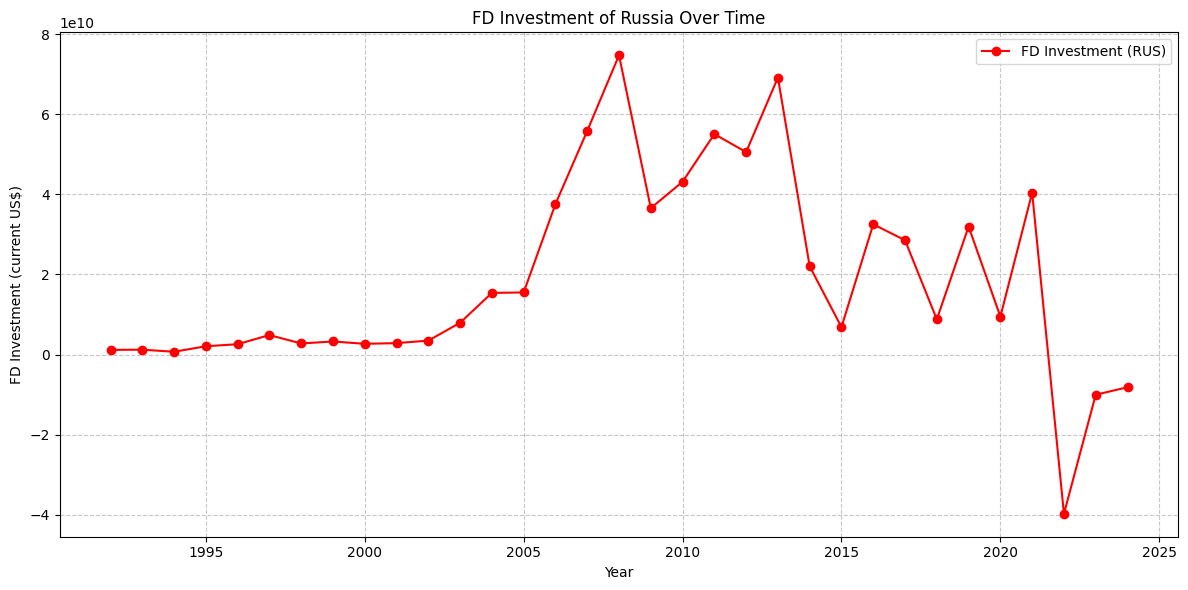

In [36]:
FD_investment_RUS_cleaned = FD_investment_RUS.dropna(subset=["FD_investment"])

# Convert the 'year' column to integer for plotting
FD_investment_RUS_cleaned["year"] = FD_investment_RUS_cleaned["year"].astype(int)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    FD_investment_RUS_cleaned["year"],
    FD_investment_RUS_cleaned["FD_investment"],
    marker="o",
    linestyle="-",
    color="red",
    label="FD Investment (RUS)"
)


# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("FD Investment (current US$)")
plt.title("FD Investment of Russia Over Time")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
df = wbdata.get_dataframe(
    indicators,
    countries,                      # 2nd positional argument: list of country codes
    (start_date, end_date),         # 3rd positional argument: tuple for date range

)

KeyboardInterrupt: 

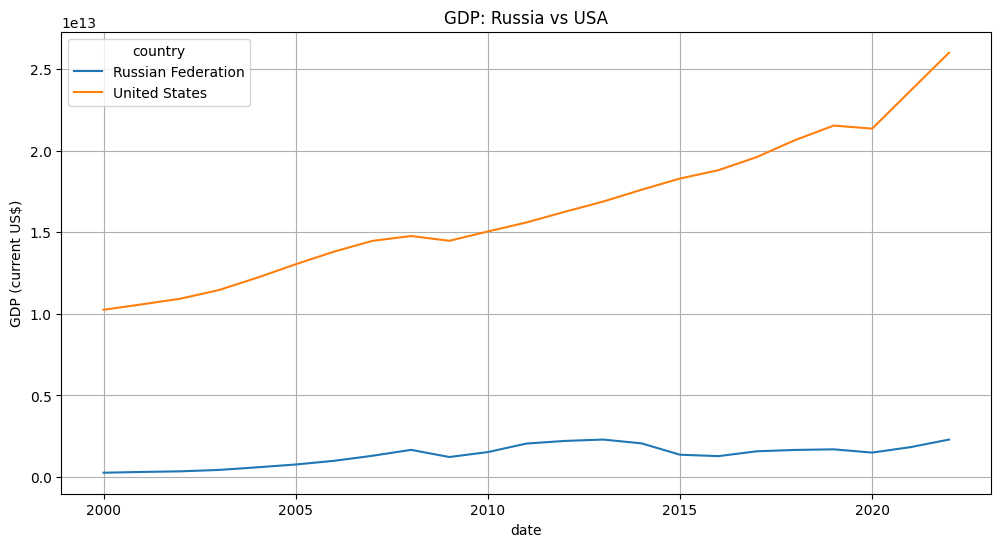

In [40]:
df_pivot = df.reset_index().pivot(index="date", columns="country", values="GDP (current US$)")
df_pivot.plot(figsize=(12,6), title="GDP: Russia vs USA")
plt.ylabel("GDP (current US$)")
plt.grid(True)
plt.show()

In [5]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend
0,2010-01-01,0,2010,1,1,1,5,False
1,2010-01-02,49,2010,1,1,2,6,True
2,2010-01-03,31,2010,1,1,3,7,True
3,2010-01-04,14,2010,1,1,4,1,False
4,2010-01-05,18,2010,1,1,5,2,False
...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False
2553,2016-12-28,17,2016,4,12,28,3,False
2554,2016-12-29,27,2016,4,12,29,4,False
2555,2016-12-30,3,2016,4,12,30,5,False


In [6]:
daily_agg["school_off"] = (
    ((daily_agg["day"] > 15) & (daily_agg["month"] == 5) & (daily_agg["day"] <= 30))
    | ((daily_agg["month"] == 6) | (daily_agg["month"] == 7))
    | ((daily_agg["day"] < 15) & (daily_agg["month"] == 8))
    | ((daily_agg["day"] > 20) & (daily_agg["month"] == 12))
)

In [7]:
daily_agg["trend"] = daily_agg.index + 1

In [8]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend
0,2010-01-01,0,2010,1,1,1,5,False,False,1
1,2010-01-02,49,2010,1,1,2,6,True,False,2
2,2010-01-03,31,2010,1,1,3,7,True,False,3
3,2010-01-04,14,2010,1,1,4,1,False,False,4
4,2010-01-05,18,2010,1,1,5,2,False,False,5
...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556


### Holiday Calendar

In [ ]:
nyse = mcal.get_calendar("NYSE")
holidays = nyse.holidays().holidays
daily_agg["isHoliday"] = daily_agg["date"].isin(holidays)

In [10]:
most_recent_holiday = max(holiday for holiday in holidays if holiday <= np.datetime64('today'))
most_recent_holiday

numpy.datetime64('2025-07-04')

In [13]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday
0,2010-01-01,0,2010,1,1,1,5,False,False,1,True
1,2010-01-02,49,2010,1,1,2,6,True,False,2,False
2,2010-01-03,31,2010,1,1,3,7,True,False,3,False
3,2010-01-04,14,2010,1,1,4,1,False,False,4,False
4,2010-01-05,18,2010,1,1,5,2,False,False,5,False
...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False


In [15]:
daily_agg.describe(include='all')

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557,2557,2557.000000,2557
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1826,1850,NaN,2493
mean,2013-07-02 00:00:00,47.867032,2013.000782,2.508408,6.522487,15.730935,4.001173,NaN,NaN,1279.000000,NaN
min,2010-01-01 00:00:00,0.000000,2010.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,NaN
25%,2011-10-02 00:00:00,14.000000,2011.000000,2.000000,4.000000,8.000000,2.000000,NaN,NaN,640.000000,NaN
50%,2013-07-02 00:00:00,28.000000,2013.000000,3.000000,7.000000,16.000000,4.000000,NaN,NaN,1279.000000,NaN
75%,2015-04-02 00:00:00,64.000000,2015.000000,4.000000,10.000000,23.000000,6.000000,NaN,NaN,1918.000000,NaN
max,2016-12-31 00:00:00,287.000000,2016.000000,4.000000,12.000000,31.000000,7.000000,NaN,NaN,2557.000000,NaN


### Define vars for analysis

In [16]:
daily_agg["q_month"] = daily_agg.groupby("month")["QUANTITY"].transform("mean")

daily_agg["QUANTITY2"] = np.where(daily_agg["QUANTITY"] < 1, 1, daily_agg["QUANTITY"])

daily_agg["q_ln"] = np.log(daily_agg["QUANTITY2"])

daily_agg["tickets"] = daily_agg.groupby(["month", "dow"])["QUANTITY"].transform("mean")

daily_agg["tickets_ln"] = daily_agg.groupby(["month", "dow"])["q_ln"].transform("mean")

daily_agg["dow_abb"] = daily_agg["date"].dt.day_name().str[:3]

daily_agg["month_abb"] = daily_agg["date"].dt.month_name().str[:3]

daily_agg


,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb
0,2010-01-01,0,2010,1,1,1,5,False,False,1,True,21.271889,1,0.000000,5.156250,1.389561,Fri,Jan
1,2010-01-02,49,2010,1,1,2,6,True,False,2,False,21.271889,49,3.891820,36.312500,3.443075,Sat,Jan
2,2010-01-03,31,2010,1,1,3,7,True,False,3,False,21.271889,31,3.433987,39.343750,3.519238,Sun,Jan
3,2010-01-04,14,2010,1,1,4,1,False,False,4,False,21.271889,14,2.639057,16.900000,2.726322,Mon,Jan
4,2010-01-05,18,2010,1,1,5,2,False,False,5,False,21.271889,18,2.890372,16.800000,2.675239,Tue,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False,15.972350,12,2.484907,14.612903,2.507322,Tue,Dec
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False,15.972350,17,2.833213,14.903226,2.470384,Wed,Dec
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False,15.972350,27,3.295837,13.093750,2.321463,Thu,Dec
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False,15.972350,3,1.098612,7.096774,1.629852,Fri,Dec


In [17]:
daily_agg["year"].value_counts()

year
2012    366
2016    366
2010    365
2011    365
2013    365
2014    365
2015    365
Name: count, dtype: int64

## Prediction

### Creat train/holdout data

In [34]:
factor_cols = ["month", "dow", "isHoliday", "school_off"]
daily_agg[factor_cols] = daily_agg[factor_cols].astype("category")

data_holdout = daily_agg.loc[daily_agg["year"] == 2016, :]

data_train = daily_agg.loc[daily_agg["year"] < 2016, :]


In [20]:
factor_cols

['month', 'dow', 'isHoliday', 'school_off']

In [21]:
logo = LeaveOneGroupOut()
groups = data_train.loc[:, "year"].to_numpy()

In [23]:
groups

array([2010, 2010, 2010, ..., 2015, 2015, 2015], dtype=int32)

In [27]:
lin_reg = LinearRegression(fit_intercept=False)

In [25]:
def fit_cv_model_get_rmse(y, X, groups):
    rmse_folds = []
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)
        y_hat = lin_reg.predict(X_test)
        rmse_folds.append(root_mean_squared_error(y_test, y_hat))

    return np.mean(rmse_folds)

## Model 0 - Linear Regression: month dummy + school off + month dummy * dow + school off * dow

In [37]:
# Model 0 linear trend + month dummy + school off + month dummy * dow + school off * dow

# training

y, X = dmatrices("QUANTITY ~ 1 + month + school_off + month * dow + school_off * dow", data_train)


rmse_reg0 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg0


26.87789027644118

In [54]:
_, X_holdout = dmatrices("QUANTITY ~ 1 + month + school_off + month * dow + school_off * dow", data_holdout)
data_holdout["y_hat_0"] = lin_reg.predict(X_holdout) # prediction 
data_holdout

/tmp/ipykernel_2660/6041513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb,y_hat_0
2191,2016-01-01,0,2016,1,1,1,5,False,False,2192,True,21.271889,1,0.000000,5.156250,1.389561,Fri,Jan,5.136364
2192,2016-01-02,16,2016,1,1,2,6,True,False,2193,False,21.271889,16,2.772589,36.312500,3.443075,Sat,Jan,36.818182
2193,2016-01-03,32,2016,1,1,3,7,True,False,2194,False,21.271889,32,3.465736,39.343750,3.519238,Sun,Jan,38.260870
2194,2016-01-04,19,2016,1,1,4,1,False,False,2195,False,21.271889,19,2.944439,16.900000,2.726322,Mon,Jan,17.863636
2195,2016-01-05,14,2016,1,1,5,2,False,False,2196,False,21.271889,14,2.639057,16.800000,2.675239,Tue,Jan,17.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False,15.972350,12,2.484907,14.612903,2.507322,Tue,Dec,42.695248
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False,15.972350,17,2.833213,14.903226,2.470384,Wed,Dec,45.334921
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False,15.972350,27,3.295837,13.093750,2.321463,Thu,Dec,43.213517
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False,15.972350,3,1.098612,7.096774,1.629852,Fri,Dec,25.646733


In [38]:
print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)

Coefficients: [[ 1.78636364e+01 -1.61363636e+00  1.45909091e+01  1.55454545e+01
   2.98444725e+01  1.07414053e+02  6.41434904e+01  2.62842312e+01
   3.54545455e+00 -1.36363636e+00 -4.05411255e+00 -1.69678769e+01
   3.86746914e+01  4.54545455e-02  3.18181818e-01  1.36363636e-01
  -1.27272727e+01  1.89545455e+01  2.03972332e+01  1.35454545e+00
   3.13636364e+00  2.09090909e+00 -8.30211709e+00  1.10128949e+01
   1.25753831e+01  6.48539693e+00 -2.97835498e+00  2.09090909e+00
   4.17748918e-01 -4.05278429e+00 -2.34848485e-01  2.93542968e-13
   2.55844156e+00 -1.34615211e+01  1.18063950e+01 -5.19576955e+00
  -1.01047376e+00 -4.91774892e+00  1.57312253e+00 -4.13419913e-01
  -4.47675358e+00 -1.63636364e+00  3.36363636e+00 -4.59307359e+00
  -1.49942435e+01 -1.07272107e+01 -9.11193408e-01  1.07342448e+00
  -5.13636364e+00 -5.00000000e-01 -4.42207792e+00 -3.13176418e+00
   6.27272727e-01 -3.31818182e+00 -5.27272727e+00 -2.07065161e+01
  -3.44766417e+00  2.24051497e+01 -5.02395288e+00 -1.87229437e

In [55]:
# graph relative RMSE (on holdout) per month

group = data_holdout.sort_values(by=["date"]).groupby("month")
rmse_monthly = pd.DataFrame(
    {
        "date": group["date"].first(),
        "RMSE": group.apply(
            lambda x: np.sqrt(mean_squared_error(x["QUANTITY"], x["y_hat_0"]))
        ),
        "RMSE_norm": group.apply(
            lambda x: np.sqrt(mean_squared_error(x["QUANTITY"], x["y_hat_0"]))
            / np.mean(x["QUANTITY"])
        ),
    }
).reset_index(drop=True)

rmse_monthly 

/tmp/ipykernel_2660/2908338174.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_2660/2908338174.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_2660/2908338174.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

,date,RMSE,RMSE_norm
0,2016-01-01,10.818982,0.480499
1,2016-02-01,12.220395,0.442436
2,2016-03-01,19.185865,0.591803
3,2016-04-01,21.176507,0.532519
4,2016-05-01,45.390762,0.732872
5,2016-06-01,36.710677,0.279878
6,2016-07-01,29.326245,0.240189
7,2016-08-01,33.835028,0.623594
8,2016-09-01,13.532540,0.510020
9,2016-10-01,17.003122,0.700927


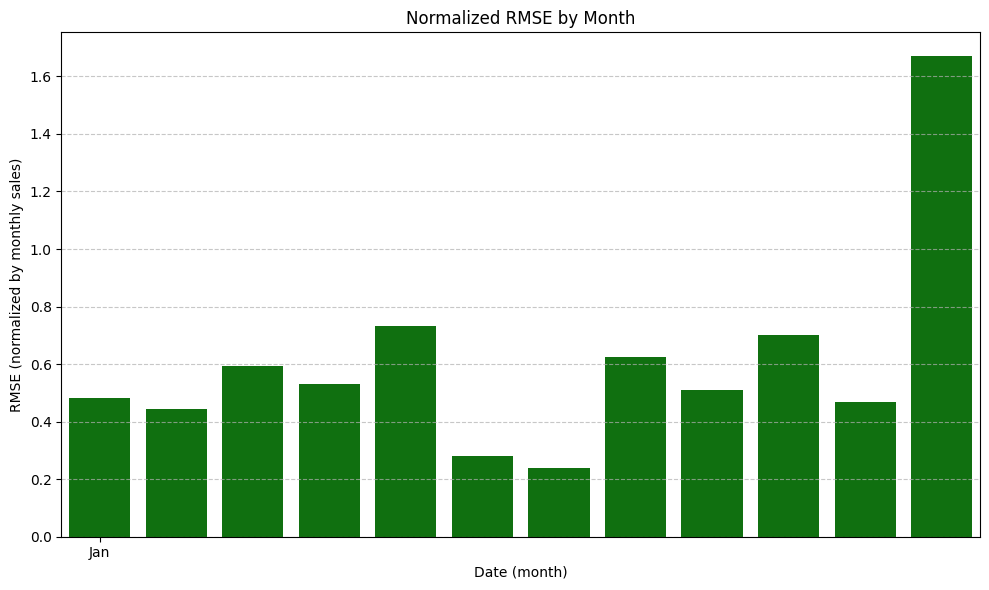

In [57]:
# Assuming `rmse_monthly` is a DataFrame with columns "date" and "RMSE_norm"
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(data=rmse_monthly, x="date", y="RMSE_norm", color="green")

# Format the x-axis to display month abbreviations
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("RMSE (normalized by monthly sales)")
plt.title("Normalized RMSE by Month")

# Apply a grid and show the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

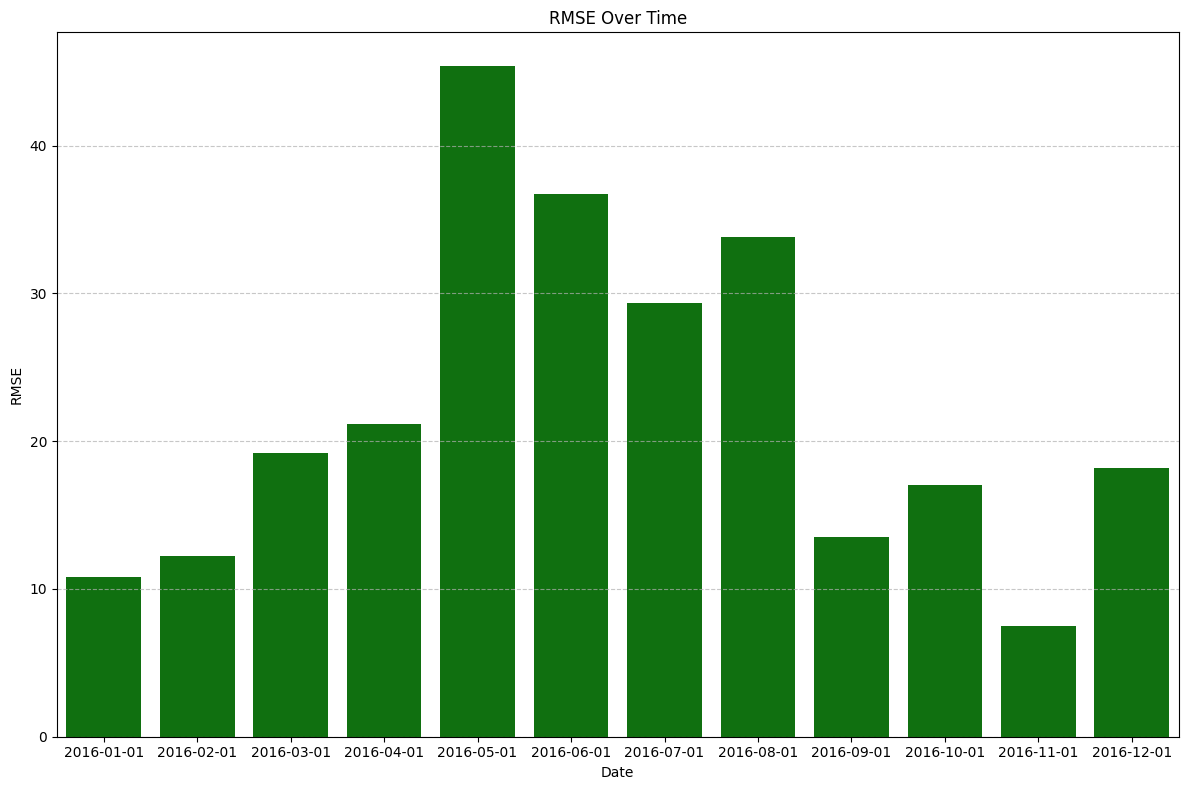

In [146]:
plt.figure(figsize=(12, 8))
sns.barplot(data=rmse_monthly, x="date", y="RMSE", color="green")
plt.xlabel("Date")
plt.ylabel("RMSE")
plt.title("RMSE Over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [156]:
plotdata = (
    data_holdout.filter(["date", "month", "QUANTITY", "y_hat_0"])
    .melt(id_vars=["date", "month"])
    .merge(data_holdout.filter(["date", "QUANTITY"]), on="date")
    .merge(data_holdout.filter(["date", "y_hat_0"]), on="date")
    .rename(columns={"q_ln": "ymin", "y_hat_0": "ymax"})
)

In [157]:
plotdata

,date,month,variable,value,QUANTITY,ymax
0,2016-01-01,1,QUANTITY,0.000000,0,5.136364
1,2016-01-02,1,QUANTITY,16.000000,16,36.818182
2,2016-01-03,1,QUANTITY,32.000000,32,38.260870
3,2016-01-04,1,QUANTITY,19.000000,19,17.863636
4,2016-01-05,1,QUANTITY,14.000000,14,17.909091
...,...,...,...,...,...,...
727,2016-12-27,12,y_hat_0,42.695248,12,42.695248
728,2016-12-28,12,y_hat_0,45.334921,17,45.334921
729,2016-12-29,12,y_hat_0,43.213517,27,43.213517
730,2016-12-30,12,y_hat_0,25.646733,3,25.646733


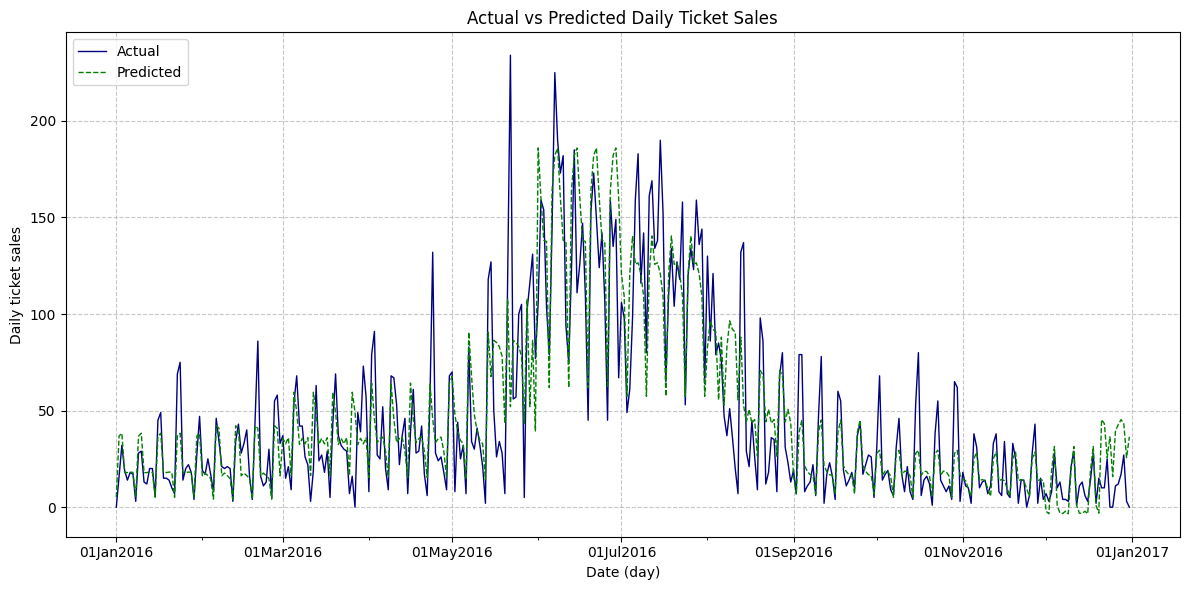

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the 'variable' column contains the expected values
plt.figure(figsize=(12, 6))

    # Plot the actual and predicted values
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'QUANTITY'],
    x='date',
    y='value',
    label='Actual',
    color='navy',
    linestyle='-',
    linewidth=1
)
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'y_hat_0'],
    x='date',
    y='value',
    label='Predicted',
    color='green',
    linestyle='--',
    linewidth=1
)
    
    # Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d%b%Y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    
    # Add labels, title, and legend
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.title("Actual vs Predicted Daily Ticket Sales")
plt.legend(loc="upper left")
    
    # Add grid
plt.grid(True, linestyle="--", alpha=0.7)
    
    # Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Models with ln Qantity

In [62]:
daily_agg.columns

Index(['date', 'QUANTITY', 'year', 'quarter', 'month', 'day', 'dow', 'weekend',
       'school_off', 'trend', 'isHoliday', 'q_month', 'QUANTITY2', 'q_ln',
       'tickets', 'tickets_ln', 'dow_abb', 'month_abb'],
      dtype='object')

In [68]:
data_train2 = data_train.loc[lambda x: x.QUANTITY >= 1]
groups = data_train2.loc[:, "year"].to_numpy()

In [102]:
data_train.shape

(2191, 18)

In [103]:
data_train2.shape

(2122, 18)

In [110]:
def fit_cv_model_get_rmse2(y, X, groups):
    rmse_folds2 = []

        # Step 1: Start Leave-One-Group-Out CV
    for train_index, test_index in logo.split(X, y, groups):

        # Step 2: Train on Training Data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)

        # Step 3: Predict on Test Data in Log Scale
        y_log_pred_test = lin_reg.predict(X_test)

        # Step 4: Estimate Bias Correction
        y_log_pred_train = lin_reg.predict(X_train)
        corrb = mean_squared_error(y_train, y_log_pred_train)

        # Step 5: Transform Predictions Back to Original Scale
        y_pred_test_corrected = np.exp(y_log_pred_test + corrb / 2)
        y_test_original = np.exp(y_test)


        rmse = root_mean_squared_error(y_test_original, y_pred_test_corrected)
        rmse_folds2.append(rmse)

    return np.mean(rmse_folds2)

In [ ]:
        # Step 2: Train on Training Data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)

        # Step 3: Predict on Test Data in Log Scale
        y_log_pred_test = lin_reg.predict(X_test)

        # Step 4: Estimate Bias Correction
        y_log_pred_train = lin_reg.predict(X_train)
        mse = mean_squared_error(y_train, y_log_pred_train)

        # Step 5: Transform Predictions Back to Original Scale
        y_pred_test_corrected = np.exp(y_log_pred_test + mse / 2)
        y_test_original = np.exp(y_test)


        rmse = root_mean_squared_error(y_test_original, y_pred_test_corrected)
        rmse_folds2.append(rmse)

In [117]:
y_log_pred_test[:5]

array([[3.05921345],
       [3.05941424],
       [3.05961502],
       [3.0598158 ],
       [3.06001658]])

In [118]:
y_log_pred_train[:5]

array([[2.69258413],
       [2.69278491],
       [2.69298569],
       [2.69318647],
       [2.69338726]])

In [120]:
corrb

0.6127064086581984

In [121]:
y_pred_test_corrected[:5]

array([[28.94989734],
       [28.95571056],
       [28.96152495],
       [28.96734051],
       [28.97315724]])

In [122]:
y_test_original[:5]

array([[ 6.],
       [34.],
       [32.],
       [16.],
       [11.]])

In [123]:
daily_agg["QUANTITY"].head()

0     0
1    49
2    31
3    14
4    18
Name: QUANTITY, dtype: int64

In [109]:
# Model 1 linear trend + monthly seasonality

y, X = dmatrices("q_ln ~ 1 + trend + month", data_train2)

rmse_reg1 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg1


37.33185180845498

In [124]:
# Model 2 linear trend + monthly seasonality + days of week seasonality

y, X = dmatrices("q_ln ~ 1 + trend + month + dow", data_train2)

rmse_reg2 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg2

45.933296849055296

In [125]:
# Model 3 linear trend + monthly seasonality + days of week  seasonality + holidays

y, X = dmatrices("q_ln ~ 1 + trend + month + dow + isHoliday", data_train2)

rmse_reg3 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg3

45.95083221582252

In [126]:
# Model 4 linear trend + monthly seasonality + days of week  seasonality + holidays + sch*dow

y, X = dmatrices("q_ln ~ 1 + trend + month + dow + isHoliday + school_off*dow", data_train2)

rmse_reg4 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg4

30.042356178792375

In [127]:
# Model 5 linear trend + monthly seasonality + days of week  seasonality + holidays + interactions

y, X = dmatrices("q_ln ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month", data_train2)

rmse_reg5 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg5 


30.27220175745228

In [136]:
y, X = dmatrices("q_ln ~ 1 + trend + month + dow + school_off*dow", data_train2)

rmse_folds2 = []
for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)

        # Step 3: Predict on Test Data in Log Scale
        y_log_pred_test = lin_reg.predict(X_test)

        # Step 4: Estimate Bias Correction
        y_log_pred_train = lin_reg.predict(X_train)
        corrb = mean_squared_error(y_train, y_log_pred_train)

        # Step 5: Transform Predictions Back to Original Scale
        y_pred_test_corrected = np.exp(y_log_pred_test + corrb / 2)
        y_test_original = np.exp(y_test)


        rmse = root_mean_squared_error(y_test_original, y_pred_test_corrected)
        rmse_folds2.append(rmse)
# NOTE: this is different from book -- TODO: check why

rmse_reg6 = np.mean(rmse_folds2)
rmse_reg6

30.028843662314078

### Prophet Model

In [137]:
# Use prophet prediction -------------------------------------------
# add CV into prophet
# can be done with prophet: https://facebook.github.io/prophet/docs/diagnostics.html
# done but this is a different cross-validation as for the other models as it must be time-series like

# prophet -  multiplicative option -- tried but produced much worse results (~34. RMSE)

# Install the prophet package
%pip install prophet

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

Note: you may need to restart the kernel to use updated packages.


In [139]:
model_prophet = Prophet(
    seasonality_mode="additive",
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    growth="linear",
    daily_seasonality=True,
)

model_prophet = Prophet.add_country_holidays(model_prophet, "US")


In [140]:
model_prophet = Prophet.fit(
    model_prophet,
    df=data_train2[["date", "q_ln"]].rename({"date": "ds", "q_ln": "y"}, axis=1),
)

23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:39 - cmdstanpy - INFO - Chain [1] done processing


In [141]:
cv_pred = cross_validation(
    model_prophet, initial="365 days", period="365 days", horizon="365 days"
)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/4 [00:00<?, ?it/s]

23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing
23:39:42 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing


In [142]:
# converting

import numpy as np
# from sklearn.metrics import mean_squared_error

# Get predicted ln(Q) and actual ln(Q)
df_cv = cv_pred[["ds", "yhat", "y"]].copy()

# Convert back to original scale
df_cv["yhat_orig"] = np.exp(df_cv["yhat"])
df_cv["y_orig"] = np.exp(df_cv["y"])

# Compute RMSE in original scale
rmse_prophet_cv = root_mean_squared_error(df_cv["y_orig"], df_cv["yhat_orig"])
print(rmse_prophet_cv)

45.80824537394864


In [143]:
df_cv

,ds,yhat,y,yhat_orig,y_orig
0,2012-01-02,3.266148,3.295837,26.210189,27.0
1,2012-01-03,3.241239,2.484907,25.565376,12.0
2,2012-01-04,3.166365,3.178054,23.721102,24.0
3,2012-01-05,2.993215,3.178054,19.949721,24.0
4,2012-01-06,1.999530,1.609438,7.385582,5.0
...,...,...,...,...,...
1412,2015-12-26,3.585889,3.367296,36.085409,29.0
1413,2015-12-28,3.049225,2.772589,21.098980,16.0
1414,2015-12-29,3.180145,3.465736,24.050238,32.0
1415,2015-12-30,3.158464,2.708050,23.534412,15.0


In [144]:
# Note: M6 log model rmse is slightly different from book
pd.DataFrame(
    [rmse_reg1, rmse_reg2, rmse_reg3, rmse_reg4, rmse_reg5, rmse_reg6, rmse_prophet_cv],
    ["M" + str(i) for i in range(1, 6)] + ["M6 (log)", "M7 (Prophet)"],
    columns=["RMSE"],
).round(2)


,RMSE
M1,37.33
M2,45.93
M3,45.95
M4,30.04
M5,30.27
M6 (log),30.03
M7 (Prophet),45.81


## Evaluate best model on holdout set

### Figure 18.6

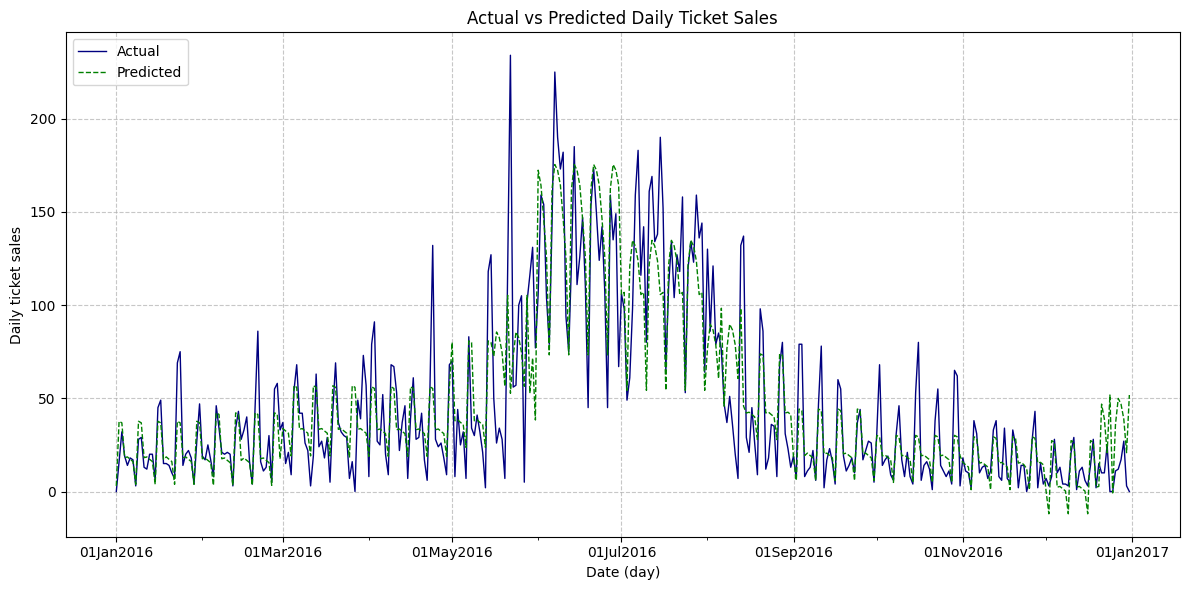

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the 'variable' column contains the expected values
plt.figure(figsize=(12, 6))

    # Plot the actual and predicted values
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'QUANTITY'],
    x='date',
    y='value',
    label='Actual',
    color='navy',
    linestyle='-',
    linewidth=1
)
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'y_hat_5'],
    x='date',
    y='value',
    label='Predicted',
    color='green',
    linestyle='--',
    linewidth=1
)
    
    # Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d%b%Y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    
    # Add labels, title, and legend
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.title("Actual vs Predicted Daily Ticket Sales")
plt.legend(loc="upper left")
    
    # Add grid
plt.grid(True, linestyle="--", alpha=0.7)
    
    # Adjust layout and show the plot
plt.tight_layout()
plt.show()


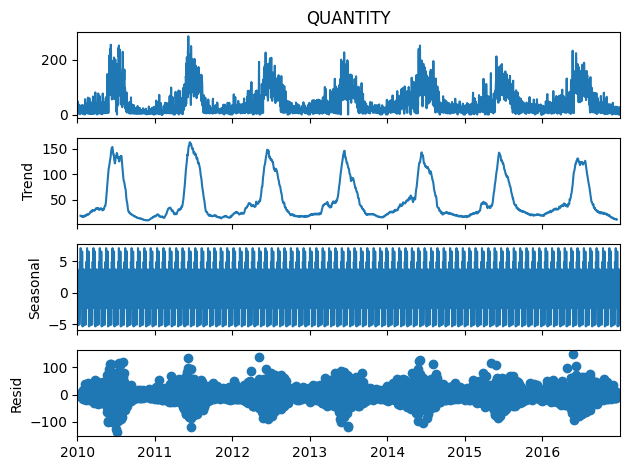

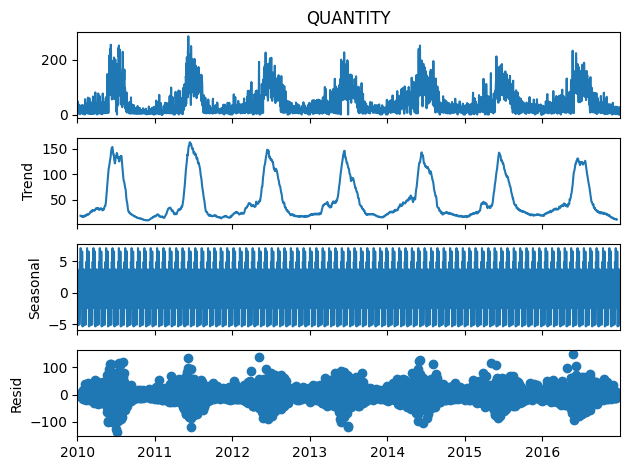

In [59]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# make sure date is datetime and set as index
daily_agg["date"] = pd.to_datetime(daily_agg["date"])
daily_agg = daily_agg.set_index("date")

# extract the series we want to analyze
series = daily_agg["QUANTITY"]

# decompose with monthly seasonality (period = 12 for monthly data)
decomp = seasonal_decompose(series, model="additive", period=30)  # 30 days ~ monthly
decomp.plot()

### Figure 18.7 a)

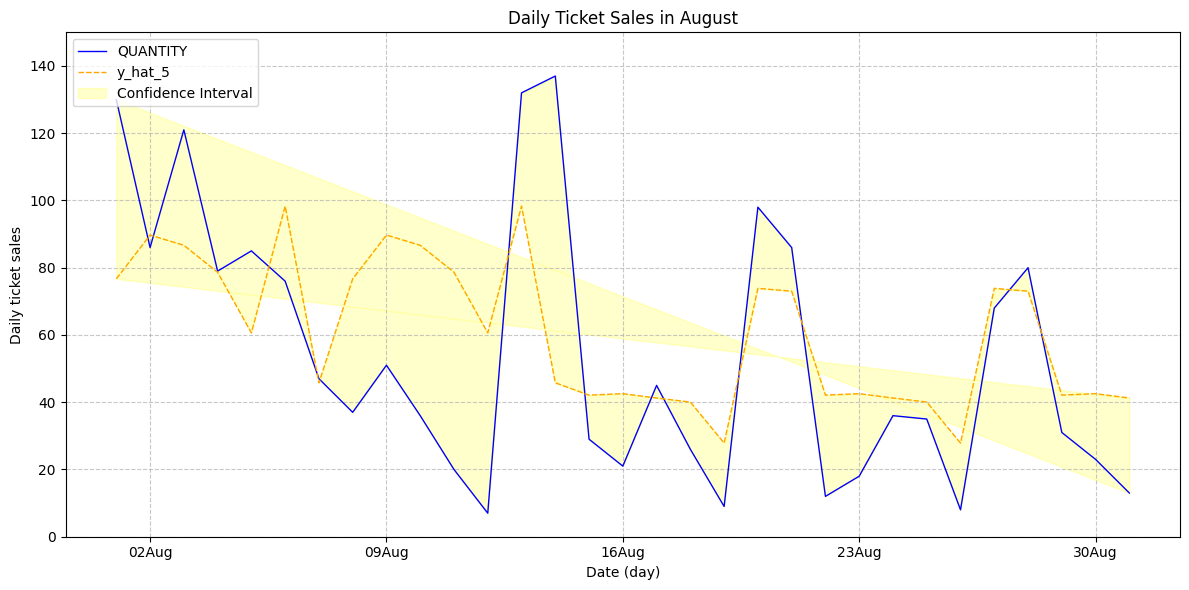

In [60]:
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for August
august_data = plotdata.loc[lambda x: x["month"] == 8].reset_index()

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
sns.lineplot(
    data=august_data,
    x="date",
    y="value",
    hue="variable",
    style="variable",
    palette={"QUANTITY": "blue", "y_hat_5": "orange"},
    linewidth=1,
)

# Add ribbon for ymin and ymax
plt.fill_between(
    august_data["date"],
    august_data["ymin"],
    august_data["ymax"],
    color="yellow",
    alpha=0.2,
    label="Confidence Interval",
)

# Format the y-axis and x-axis
plt.ylim(0, 150)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d%b"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

# Add labels, title, and legend
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.title("Daily Ticket Sales in August")
plt.legend(loc="upper left")

# Apply grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()